### Modules For the Analysis and Create Initial Data

In [1]:
import pandas as pd
from sklearn.cluster import Ward
import matplotlib.pyplot as plt
import numpy as np
from pandas import merge
from sklearn.decomposition import PCA
from pandas import merge
from __future__ import division
from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix


#Note, Spendradar creates the csv and adds something called a "BOM" to the front, impacting the first column header.
#Remove it by opening the csv in Notepad++ and changing the encoding to utf-8 without BOM.  Or just use the following:
# awk '{ if (NR==1) sub(/^\xef\xbb\xbf/,""); print }' Data_2.csv > Data2.csv

#Data is from SpendRadar and has the following format:
#Campus|UNSPSC Level 2|Supplier Normalized Name|Department Name|Org Level 4|Org Level 5|Spend Date|# of Lines|# of POs|# of Invoices

#Set the level of the organization (I reccomend 'Org Level 3')
Org_Level = 'Department Name'

#read in data, strip comma's out of the values and convert them to floats, index by "campus,Org"
#The parse dates option increases the loading time, be patient.
df = pd.read_csv('Data2.csv', 
                 parse_dates=[4],
                 thousands=',')

supplier_filter = '|'.join(['FISHER SCIENTIFIC',
                            'VWR',
                            'SIGMA ALDRICH',
                            'BIOEXPRESS',
                            'LIFE TECHNOLOGIES CORP',
                            'USA SCIENTIFIC',
                            'DENVILLE',
                            'CLONTECH',
                            'GE HEALTHCARE BIO',
                            'NEW ENGLAND BIO',
                            'SPECTRUM CHEMICAL', 
                            'SPECTRUM LABORATORY',
                            'PROMEGA'
                            ])


#Filter down to the data of interest, in this case by supplier. 
df_filtered = df[df['Supplier Normalized Name'].str.contains(supplier_filter) & (df['Spend'] > 0)]

#find the number of Suppliers in the dataset
N_Suppliers = df_filtered['Supplier Normalized Name'].nunique()


### Analyze and vizualize the features using Glue

In [2]:
from glue import qglue

#Create a summary pivot for departments
Dept_Summary = df_filtered.pivot_table(rows=['Campus',Org_Level], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()

#pivot out by campus, department, and date then find the summary stats of the time based dimensions
#Create a frame that is grouped by month and sum of all values
dept_time = df_filtered.pivot_table(rows=['Campus',Org_Level,'Spend Date' ], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()

dept_time = dept_time.groupby(['Campus',Org_Level,dept_time['Spend Date'].map(lambda x: (x.month,x.year))]).sum().reset_index()

avg_monthly = dept_time.groupby(['Campus',Org_Level]).mean()
Count_Months = pd.DataFrame(dept_time.groupby(['Campus',Org_Level]).count()['Spend Date'])

qglue(DepartmentSummary=dept_time.reset_index())  




TypeError: pyqtSignal must be bound to a QObject, not 'MplCanvas'

C:\Anaconda\lib\site-packages\pandas\util\decorators.py:53: FutureWarning: rows is deprecated, use index instead
  warnings.warn(msg, FutureWarning)


DataCollection (1 data set)
	  0: DepartmentSummary

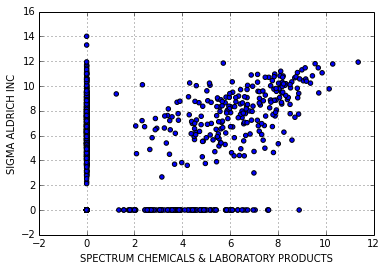

In [3]:
from numpy import inf

Spend_per_Supplier = df_filtered.pivot_table(rows=['Campus',Org_Level], cols='Supplier Normalized Name', values='Spend', aggfunc=np.sum, fill_value=0) 
test = Spend_per_Supplier
test = pd.DataFrame(np.log(Spend_per_Supplier))
test.fillna(value=0)
test[test == -inf] = 0
test

test.plot(kind='scatter', x='SPECTRUM CHEMICALS & LABORATORY PRODUCTS', y='SIGMA ALDRICH INC')

### Create the Feature Space

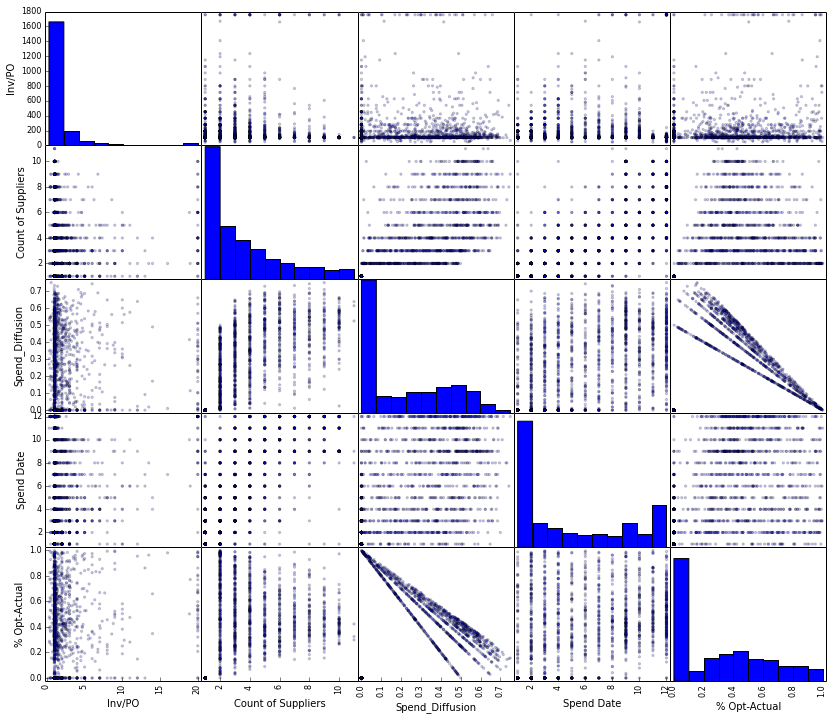

In [2]:
#Create a set of features for the total spend per supplier per department
Spend_per_Supplier = df_filtered.pivot_table(rows=['Campus',Org_Level], cols='Supplier Normalized Name', values='Spend', aggfunc=np.sum, fill_value=0) 



#Create the Invoice Per PO feature
PO_by_Inv = df_filtered.pivot_table(rows=['Campus',Org_Level], values=['# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0)
cutoff = 20
#Replace # of PO = 0 with a .01 so that we can avoid INF errors
PO_by_Inv.replace(0,1,True)
#Divide
PO_by_Inv['Inv/PO'] = (PO_by_Inv['# of Invoices']/PO_by_Inv['# of POs'])
#Take care of inf
PO_by_Inv['Inv/PO'].replace('inf',cutoff,True)
#Drop unnecessary columns
PO_by_Inv = PO_by_Inv.drop(['# of Invoices','# of POs'],1)
#Filter out the outliers and change them to a "cutoff"
PO_by_Inv['Inv/PO'][PO_by_Inv['Inv/PO'] > cutoff] = cutoff
Log_PO_by_Inv = pd.DataFrame(np.log(PO_by_Inv))



#IS IT POSSIBLE (OR WORTH IT) TO CODE THESE AS 1 LINE FUNCTIONS OFF THE SPEND_PER_SUPPLIER DATAFRAME???????????

#Create the supplier count feature
Count_Supplier= DataFrame(df_filtered.pivot_table(rows=['Campus',Org_Level],values='Supplier Normalized Name',aggfunc=lambda x: len(x.unique())))
Count_Supplier = Count_Supplier.rename(columns={'Supplier Normalized Name':'Count of Suppliers'})

#Create the Spend Diffusion Metric
Max_Supplier_Spend = df_filtered.pivot_table(rows=['Campus',Org_Level,'Supplier Normalized Name'], 
                                          values=['Spend'], aggfunc=np.sum, fill_value=0).reset_index().groupby(['Campus',Org_Level]).max().drop(['Supplier Normalized Name'],1)

Total_Dept_Spend = df_filtered.pivot_table(rows=['Campus',Org_Level], 
                                          values=['Spend'], aggfunc=np.sum, fill_value=0)

Spend_Diffusion = 1-(Max_Supplier_Spend/Total_Dept_Spend)
Spend_Diffusion = Spend_Diffusion.rename(columns={'Spend': 'Spend_Diffusion'})
Log_Spend_Diffusion = pd.DataFrame(np.log(Spend_Diffusion))


#Create Spend Frequency and Average Monthly Spend/PO/Invoice Features
Dept_Summary = df_filtered.pivot_table(rows=['Campus',Org_Level], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()
#pivot out by campus, department, and date then find the summary stats of the time based dimensions
#Create a frame that is grouped by month and sum of all values
dept_time = df_filtered.pivot_table(rows=['Campus',Org_Level,'Spend Date' ], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()
dept_time = dept_time.groupby(['Campus',Org_Level,dept_time['Spend Date'].map(lambda x: (x.month,x.year))]).sum().reset_index()
avg_monthly = pd.DataFrame(dept_time.groupby(['Campus',Org_Level]).mean()['Spend'])
Count_Months = pd.DataFrame(dept_time.groupby(['Campus',Org_Level]).count()['Spend Date'])


#Merge all the features into the Department_Analysis Frame (Un-comment to run these)
Department_Analysis = pd.merge(Spend_per_Supplier,PO_by_Inv,left_index=True, right_index=True,how='left')
Department_Analysis = pd.merge(Department_Analysis,Count_Supplier,left_index=True, right_index=True,how='left')
Department_Analysis = pd.merge(Department_Analysis,Spend_Diffusion,left_index=True, right_index=True,how='left').fillna(0)
Department_Analysis = pd.merge(Department_Analysis,Count_Months,left_index=True, right_index=True,how='left').fillna(0)
#Department_Analysis = pd.merge(Department_Analysis,Log_PO_by_Inv,left_index=True, right_index=True,how='left').fillna(0)
#Department_Analysis = pd.merge(Department_Analysis,avg_monthly,left_index=True, right_index=True,how='left').fillna(0)



#For some reason 1/Department_Analysis['Count of Suppliers'] didn't work so I created column of all 1
Department_Analysis['one']=1
Department_Analysis['Optimal Diffusion']= Department_Analysis['one']-(Department_Analysis['one']/Department_Analysis['Count of Suppliers'])
Department_Analysis['% Opt-Actual'] = (Department_Analysis['Optimal Diffusion']-Department_Analysis['Spend_Diffusion'])/Department_Analysis['Optimal Diffusion']
Department_Analysis['% Opt-Actual']=Department_Analysis['% Opt-Actual'].fillna(0)
Department_Analysis[Department_Analysis['Spend_Diffusion']==-inf] = 0

del Department_Analysis['one']
del Department_Analysis['Optimal Diffusion']

#Calculate the number of non-Supplier Spend dimensions
NonSupplier_Features = len(Department_Analysis.columns) - N_Suppliers


#Create a scatterplot matrix to analyze the features
scatter_matrix(Department_Analysis.ix[:,-NonSupplier_Features:], alpha=0.2, figsize=(14, 12))


#This is a standardization of each columnwise data element by subtracting the column mean and dividing by the column standard deviation.
for col in Department_Analysis.columns:
    Department_Analysis[col + '_stdard'] = (Department_Analysis[col] - Department_Analysis[col].mean()) / Department_Analysis[col].std()

### How many clusters should we have?

In [13]:
Department_Analysis

BIOEXPRESS LLC  \
Campus Department Name                                  
UCB    AACHN Calif Hall Bldg Mgmt                0.00   
       AACHN Chan Off Immed Office               0.00   
       AACHN Univ House Maint & Rep              0.00   
       ABCFI AVC CFO Immed Office                0.00   
       AIDVO ADM Business Ops/Svcs-DO            0.00   
       AIDVO Advancement Info Mgmt               0.00   
       AIDVO Ext Relat & Protocol-DO             0.00   
       ALPDC DPM Project Management              0.00   
       ALPDC Plant Expenditures Proj             0.00   
       AZCSS Benefits                            0.00   
       AZCSS General Admin                       0.00   
       BAHSB B&O Schoolwd Services               0.00   
       BAHSB BO Admin Stockroom                  0.00   
       BAHSB Behavioral Lab                      0.00   
       BAHSB Career Gen Ops                      0.00   
       BAHSB Career Recruitment Ctr              0.00   
       BAHSB Dean Gen Ops                        0.00   
       BAHSB ECSM Bldg Furnishings               0.00   
       BAHSB ECSM Bldg Gen Ops                   0.00   
       BAHSB ECSM Bldg Maintenance               0.00   
       BAHSB ECSM Lab Svcs                       0.00   
       BAHSB ECSM Media Svc                      0.00   
       BAHSB Instr EVMBA Gen Ops                 0.00   
       BAHSB Instr UG Gen Ops                    0.00   
       BCHCI UCBEI Research                      0.00   
       BOOPT AA Temp Instruc Costs               0.00   
       BOOPT DN Trainees                       323.27   
       BOOPT ER Development                      0.00   
       BOOPT RS Other                            0.00   
       BOOPT RS Post Award Federal             871.09   
       BOOPT RS Post Award Other                 0.00   
       BOOPT RS Post Award Private             238.28   
       BPOPC GO Clinic Admin & Supp              0.00   
       BPOPC PC Minor Hall Clinics               0.00   
       BPOPC PC Refractiv Surgery Ctr            0.00   
       BQRES DN Trainees                      3209.04   
       BQRES RS Other                            0.00   
       BQRES RS Post Award Federal             428.26   
       BQRES RS Post Award Private               0.00   
       BRCOE OLE OnlineEdInitiatveOps            0.00   
       CCHEM INSTR Ops                         100.49   
       CCHEM RES Research                      817.81   
       CDCDN An CHEXRAY Ops                      0.00   
       CDCDN An Microlab Ops                     0.00   
       CDCDN An NMR Ops                          0.00   
       CDCDN BAS/Mat Mgmt Stores Ops             0.00   
       CDCDN Bio-Safety Lab 3                    0.00   
       CDCDN Chem R&D Engineering Svc            0.00   
       CDCDN Dean Endowment & Gifts              0.00   
       CDCDN Dean Reserve                        0.00   
       CDCDN E/F Facilities Ops                  0.00   
       CDCDN EH&S Ops                            0.00   
       CDCDN Undergrad Aff Ops                   0.00   
       CEEEG Gen Ops                             0.00   
       CEEEG Inst. TAS                           0.00   
       CEEEG RES Research                     1114.85   
       CITRS Operating Funds                     0.00   
       CKGEN OPS Operating Expenses              0.00   
       CLLAW ADM Bud,Plng&AcPersonnel            0.00   
       CLLAW ADM Building Services               0.00   
                                                  ...   

                                       CLONTECH A TAKARA BIO CO  \
Campus Department Name                                            
UCB    AACHN Calif Hall Bldg Mgmt                             0   
       AACHN Chan Off Immed Office                            0   
       AACHN Univ House Maint & Rep                           0   
       ABCFI AVC CFO Immed Office                             0   
       AIDVO ADM Business Ops/Svcs-DO        

C:\Anaconda\lib\site-packages\numpy\core\_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


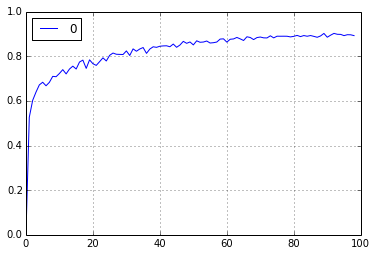

In [163]:
#Use the silhouette score to test the cluster density at different numbers of clusters.
from sklearn import metrics


def ClusterDistance(FeatureMatrix, minRange, maxRange):
    sil=[0]
    for k in range(minRange,maxRange):
        ward = Ward(n_clusters=k)
        FeatureMatrix['category'] = ward.fit_predict(FeatureMatrix)
        #Run the Silouette Score to test the quality of the clusters
        sil.append(metrics.silhouette_score(FeatureMatrix.values, FeatureMatrix['category'].values, metric='euclidean'))
    return sil
    
#Update the input to the function here:
pd.DataFrame(ClusterDistance(Department_Analysis.ix[:,-4:],2,100)).plot(kind='line')


### Cluster and Observe the Results


Silouette Score: 0.59339331472
('Variance Explained By Feature: [ 0.55742215  0.20275371  0.14274583]', 0.90292169815142909)


C:\Anaconda\lib\site-packages\matplotlib\axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


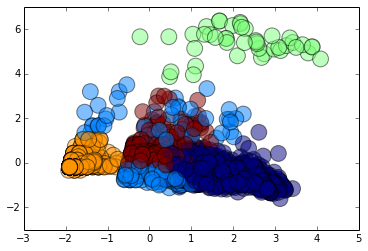

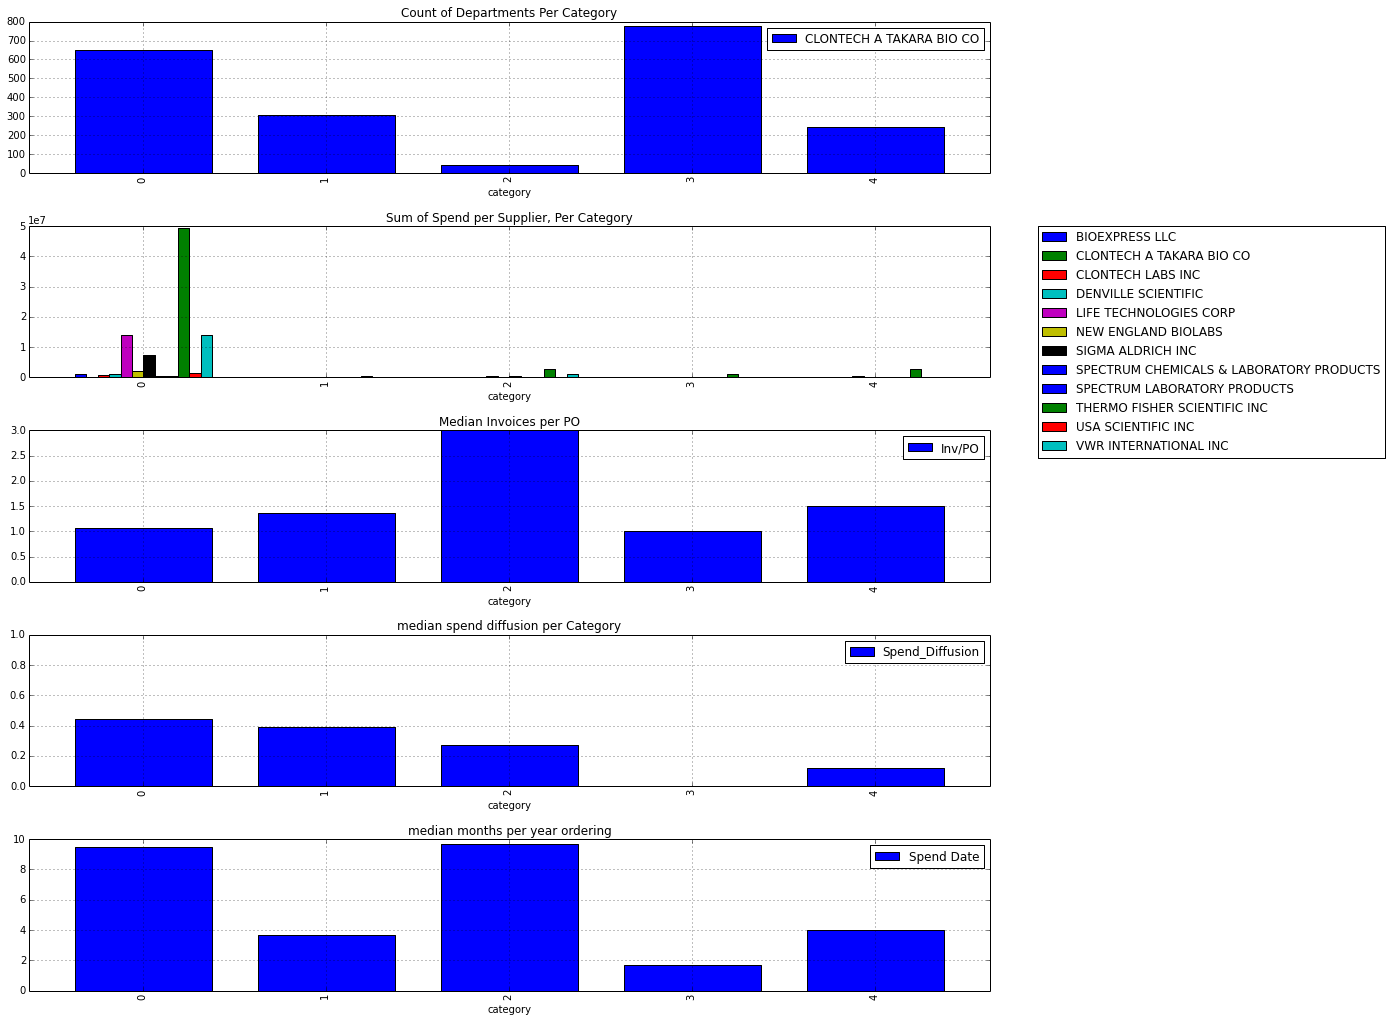

In [3]:
#Reduce dimensionality down to 2 axes


#Drop the category column if it exists
for col in Department_Analysis.columns:
    if col is 'category':
        Department_Analysis = Department_Analysis.drop(col,1)
        
        
#Use PCA to reduce dimensionality to 2 to check the variance explained and inspect the clusters
pca = PCA(n_components=3).fit_transform(Department_Analysis.ix[:,-NonSupplier_Features:])
pcaT = PCA(n_components=3).fit(Department_Analysis.ix[:,-NonSupplier_Features:])


#Run the heirarchical clustering
ward = Ward(n_clusters=5)
Department_Analysis['category'] = ward.fit_predict(Department_Analysis.ix[:,-NonSupplier_Features:])

#Run the Silouette Score to test the quality of the clusters
from sklearn.metrics import pairwise_distances
from sklearn import metrics


print('\nSilouette Score: %s' % metrics.silhouette_score(Department_Analysis.ix[:,-NonSupplier_Features:].values, Department_Analysis['category'].values, metric='euclidean'))
print('Variance Explained By Feature: %s' % pcaT.explained_variance_ratio_, sum(pcaT.explained_variance_ratio_))


#Run PCA and chart the two leading Components to see what the clusters look like in 2D space
sc = plt.scatter(pca[:,0],pca[:,1], s=250, c=Department_Analysis.category, alpha=0.5, edgecolors='black')
plt.legend()
plt.show()

#Group the data by supplier and plot it to see the spend per supplier/per cluster.
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(14, 14))
fig.tight_layout()
fig.subplots_adjust(hspace=.35)
ax1 = Department_Analysis.groupby('category').count()[[1]].plot(kind='bar',ax=axes[0], title='Count of Departments Per Category', label=None)
ax2 = Department_Analysis.groupby('category').sum()[[x for x in Department_Analysis.columns[0:N_Suppliers]]].plot(kind='bar',ax=axes[1], title='Sum of Spend per Supplier, Per Category').legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax3 = Department_Analysis.groupby('category').median()[['Inv/PO']].plot(kind='bar',ax=axes[2], title='Median Invoices per PO')
ax3.set_ylim(0,3)
ax4 = Department_Analysis.groupby('category').median()[['Spend_Diffusion']].plot(kind='bar',ax=axes[3], title='median spend diffusion per Category')
ax4.set_ylim(0,1)
ax5 = Department_Analysis.groupby('category').mean()[['Spend Date']].plot(kind='bar',ax=axes[4], title='median months per year ordering')

In [8]:
#Print all the members of one or more of the categories
Department_Analysis[Department_Analysis['category'] == 0].loc['UCSF']

BIOEXPRESS LLC  CLONTECH A TAKARA BIO CO  \
Department Name                                                            
-                                      1205.70                         0   
AIDS RESEARCH INSTITUTE                   0.00                         0   
ANATOMY                               11269.82                         0   
ANESTHESIA/PERIOPERATIVE CARE          3561.25                         0   
ANESTHESIA/YOUNG                        261.08                         0   
BIOCHEMISTRY & BIOPHYSICS              8318.41                         0   
BIOENGINEERING&THERAPEUTIC SCI         7023.69                         0   
BIOENGINEERING/THERAPEUTIC SCI          911.58                         0   
CANCER CENTER                          1288.98                         0   
CARDIOVASCULAR RESEARCH INST          25155.64                         0   
CELL CULTURE                              0.00                         0   
CELLULAR & MOLECULAR PHARMACOL         7152.32                         0   
CLINICAL LABS SFGH                        0.00                         0   
CLINICAL PHARMACY                         0.00                         0   
CTSI-CRS-ALL SITES                      115.66                         0   
CTSI-SOM SOS AWARDS                      46.33                         0   
CTSI-SOM-MEDICINE                         0.00                         0   
CTSI-SOM-NEUROLOGY                        0.00                         0   
CTSI-SOM-SURGERY                        206.00                         0   
CTSI-SOP-BIOPHARM SCIENCES              115.66                         0   
CTSI-TRAINING                             0.00                         0   
DEAN'S OFF GRAD RESCH AFFAIRS             0.00                         0   
DENT-ORAL & MAX SURGERY                   0.00                         0   
DEPT OF CELL & TISSUE BIOLOGY          2627.18                         0   
DEPT OF OROFACIAL SCIENCES                0.00                         0   
DERMATOLOGY                            3561.01                         0   
DIABETES CENTER                       14499.05                         0   
DISTRIBUTION & STORAGE                    0.00                         0   
DRUG STUDIES UNIT                         0.00                         0   
ENVIRONMENTAL HEALTH & SAFETY             0.00                         0   
EPIDEMIOLOGY & BIOSTATISTICS            238.55                         0   
FAMILY HLTH CARE NSG                    217.80                         0   
GLOBAL HEALTH GROUP                       0.00                         0   
GRADUATE DIVISION                        67.21                         0   
GREENBLATT RESEARCH UNIT                  0.00                         0   
HDFCCC OPERATIONS & ADMIN              1574.47                         0   
HDFCCC PI LABS                         7306.10                         0   
HOOPER FOUNDATION                         0.00                         0   
HORMONE RESEARCH LAB                   1804.38                         0   
HOWARD HUGHES MEDICAL INST                0.00                         0   
INST FOR NEURODEGENERATIVE DIS        10029.86                         0   
INST FOR REGENERATION MEDICINE         1271.18                         0   
INSTITUTE FOR HUMAN GENETICS           5510.68                         0   
LAB ANIMAL RESOURCE CENTER              166.28                         0   
LABORATORY MEDICINE                    3668.74                         0   
LABORATORY MEDICINE-VAN'T VEER            0.00                         0   
LPPI:  INSTR & RESEARCH                 127.40                         0   
MASS SPECTROMETRY                        71.61                         0   
MED-CAMPUS-ADMIN                         39.34                         0   
MED-CAMPUS-CARDIO                      2225.04                         0   
MED-CAMPUS-GENOMIC MEDICINE              40.96                         0   
MED-

In [44]:
#Department Histogram Data (ignore the header)
#Department_Analysis.groupby('category').count()[[1]]

#Supplier Spend by Category
#Department_Analysis.groupby('category').sum()[[x for x in Department_Analysis.columns[0:N_Suppliers]]]

#Median INV/PO per cluster
#Department_Analysis.groupby('category').median()[['Inv/PO']]

#Median Spend Diffusion per cluster
#Department_Analysis.groupby('category').median()[['Spend_Diffusion']]

#Median Spend Date
Department_Analysis.groupby('category').median()[['Spend Date']]


,Spend Date
category,
0,10
1,3
2,11
3,1
4,4


In [9]:
Department_Analysis.to_csv('c:/users/aclark/desktop/clustered.csv')